In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)
%matplotlib inline

from IPython.core.display import display, HTML

In [2]:
price_df = pd.read_csv('zillow-yearly-ca.csv').rename(columns={'RegionName': 'county'})
price_df['county'] = price_df['county'].apply(lambda x: x.replace(' County', ''))
price_df['fips_code'] = price_df.apply(lambda x: f'{x.fips_code:05}', axis=1).tolist()
display(price_df)
print(f'Number of counties: {len(price_df.fips_code.unique())}')

,fips_code,county,year,price
0,06001,Alameda,2000,302255.314092
1,06001,Alameda,2001,368098.179928
2,06001,Alameda,2002,393708.303015
3,06001,Alameda,2003,427010.475210
4,06001,Alameda,2004,484363.003599
...,...,...,...,...
1387,06115,Yuba,2019,291275.185476
1388,06115,Yuba,2020,314465.065842
1389,06115,Yuba,2021,371635.057158
1390,06115,Yuba,2022,413854.162305


Number of counties: 58


In [3]:
income_df = pd.read_csv('Income_with_FIPS.csv').rename(columns={'taxable_year': 'year'})
income_df['fips_code'] = income_df.apply(lambda x: f'{x.fp:05}', axis=1).tolist()
income_df = income_df[['fips_code', 'year', 'county', 'population', 'median_income']]
display(income_df)
print(f'Number of counties: {len(income_df.fips_code.unique())}')

,fips_code,year,county,population,median_income
0,06001,1995,Alameda,1347700,28329
1,06003,1995,Alpine,1200,23999
2,06005,1995,Amador,32600,24729
3,06007,1995,Butte,196100,20036
4,06009,1995,Calaveras,36950,23563
...,...,...,...,...,...
1503,06107,2020,Tulare,473482,30151
1504,06109,2020,Tuolumne,55500,39102
1505,06111,2020,Ventura,844545,44494
1506,06113,2020,Yolo,216544,44881


Number of counties: 58


In [4]:
burn_df = pd.read_csv('cleaned_fire_percent.csv').rename(columns={'YEAR_': 'year', 'NAMELSAD': 'county'})
burn_df['county'] = burn_df['county'].apply(lambda x: x.replace(' County', ''))
fips = burn_df.apply(lambda x: f'{x.STATEFP:02}{x.COUNTYFP:03}', axis=1).tolist()
burn_df.insert(0, 'fips_code', fips)
burn_df = burn_df[['fips_code', 'year', 'county', 'total_burn_pyr', 'perc_burn']]
burn_df['year'] = burn_df['year'].astype(int)
display(burn_df)
print(f'Number of counties: {len(burn_df.fips_code.unique())}')

,fips_code,year,county,total_burn_pyr,perc_burn
0,06091,2000,Sierra,6.748577e+04,0.002711
1,06091,2001,Sierra,2.753879e+06,0.110615
2,06091,2003,Sierra,2.429302e+05,0.009758
3,06091,2004,Sierra,1.117228e+06,0.044876
4,06091,2005,Sierra,9.159885e+06,0.367926
...,...,...,...,...,...
1081,06079,2018,San Luis Obispo,5.988013e+06,0.063943
1082,06079,2019,San Luis Obispo,2.196040e+07,0.234503
1083,06079,2020,San Luis Obispo,4.020842e+07,0.429363
1084,06079,2021,San Luis Obispo,8.947344e+05,0.009554


Number of counties: 57


In [5]:
burn_df.groupby('county').perc_burn.describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Alameda,13.0,0.625568,1.250932,0.000104,0.057891,0.208459,0.534204,4.661646
Alpine,15.0,1.505175,3.003742,0.001034,0.013808,0.050677,1.793490,11.399352
Amador,18.0,0.447773,1.044470,0.002640,0.025072,0.094027,0.309325,4.499382
Butte,22.0,2.009805,4.374440,0.002557,0.065495,0.185676,0.817083,14.449272
Calaveras,21.0,0.765371,2.189820,0.008692,0.068884,0.121202,0.283336,10.137126
Colusa,15.0,1.416518,3.034631,0.000085,0.012913,0.062672,0.926479,9.968643
Contra Costa,13.0,0.173846,0.227060,0.003367,0.048018,0.087377,0.143921,0.696944
Del Norte,14.0,1.518981,2.084074,0.000064,0.005181,0.047422,3.542272,5.467990
El Dorado,21.0,1.400772,4.308082,0.000624,0.026260,0.059668,0.364004,19.235707


In [6]:
input_df = price_df.merge(income_df, on=['fips_code', 'year', 'county'], how='left').merge(burn_df, on=['fips_code', 'year', 'county'], how='left')
print(f'Number of counties: {len(input_df.fips_code.unique())}')
display(input_df)
input_df = input_df.drop(columns=['county'])
# There are missing values for percent burn, should we fill with zeros or interpolate?
input_df = input_df.interpolate(method='linear', axis=0).ffill().bfill()
# Remove data from 2020 onwards
input_df = input_df[input_df.year<=2020]
# Remove outliers from 2007-2012 (when the housing crash happened)
#input_df = input_df[(input_df.year<2007) | (input_df.year>2012)]
display(input_df)

Number of counties: 58


,fips_code,county,year,price,population,median_income,total_burn_pyr,perc_burn
0,06001,Alameda,2000,302255.314092,1466900.0,37580.0,3.052264e+05,0.014358
1,06001,Alameda,2001,368098.179928,1479300.0,38582.0,4.758508e+05,0.022384
2,06001,Alameda,2002,393708.303015,1488000.0,38044.0,1.230661e+06,0.057891
3,06001,Alameda,2003,427010.475210,1493928.0,38411.0,1.642332e+07,0.772567
4,06001,Alameda,2004,484363.003599,1497251.0,39779.0,NaN,NaN
...,...,...,...,...,...,...,...,...
1387,06115,Yuba,2019,291275.185476,79089.0,36246.0,9.799734e+05,0.058805
1388,06115,Yuba,2020,314465.065842,81468.0,37086.0,9.755447e+06,0.585390
1389,06115,Yuba,2021,371635.057158,NaN,NaN,7.002048e+06,0.420168
1390,06115,Yuba,2022,413854.162305,NaN,NaN,1.145039e+06,0.068710


,fips_code,year,price,population,median_income,total_burn_pyr,perc_burn
0,06001,2000,302255.314092,1466900.0,37580.0,3.052264e+05,0.014358
1,06001,2001,368098.179928,1479300.0,38582.0,4.758508e+05,0.022384
2,06001,2002,393708.303015,1488000.0,38044.0,1.230661e+06,0.057891
3,06001,2003,427010.475210,1493928.0,38411.0,1.642332e+07,0.772567
4,06001,2004,484363.003599,1497251.0,39779.0,1.841302e+07,0.866164
...,...,...,...,...,...,...,...
1384,06115,2016,223107.534460,76138.0,32937.0,2.255334e+06,0.135335
1385,06115,2017,248179.174297,76767.0,33537.0,5.347435e+07,3.208806
1386,06115,2018,273093.321349,77426.0,34903.0,2.818490e+05,0.016913
1387,06115,2019,291275.185476,79089.0,36246.0,9.799734e+05,0.058805


<AxesSubplot:xlabel='price', ylabel='Count'>

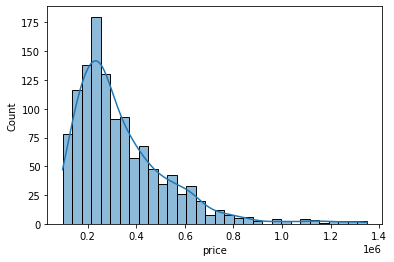

In [7]:
sns.histplot(data=input_df, x='price', kde=True)

<AxesSubplot:xlabel='median_income', ylabel='Count'>

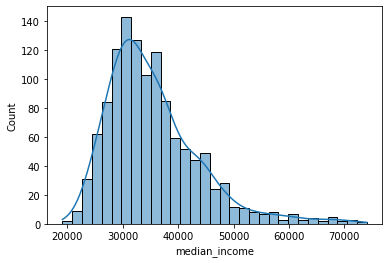

In [8]:
sns.histplot(data=input_df, x='median_income', kde=True)

In [ ]:
sns.relplot(
    data=input_df,
    x="year", y="perc_burn",
    col="fips_code",
    kind="line",
    col_wrap=4,
)

In [ ]:
# Compute percent increase in price from previous years
lag = 1
df = input_df
shifted = input_df.groupby(by=['fips_code']).shift(lag).drop(columns=['year', 'population', 'median_income', 'total_burn_pyr', 'perc_burn'])
df = df.join(shifted.rename(columns=lambda x: f"{x}_prev_{lag}"))
#df = df.drop(columns=input_df.columns[3:])
# Remove the first N rows since it doesn't have data from previous N years to make prediction
df = df[~df.isnull().any(axis=1)].reset_index(drop=True)
percent_increase = df.apply(lambda x: (x.price-x.price_prev_1)*100.0/x.price_prev_1, axis=1)
percent_df = df.drop(columns=['price_prev_1'])
percent_df.insert(2, 'percent_increase', percent_increase)
display(percent_df)

In [ ]:
fips_code = '06113'
county_burn_df = percent_df[percent_df.fips_code==fips_code]
display(county_burn_df)

In [ ]:
# Join last 3 year data per row
N = 3
#use_data = input_df
use_data = percent_df
df = use_data
for lag in range(1, N+1):
    shifted = use_data.groupby(by=['fips_code']).shift(lag).drop(columns=['year', 'percent_increase'])
    df = df.join(shifted.rename(columns=lambda x: f"{x}-prev_{lag}"))
df = df.drop(columns=use_data.columns[3:])
# Remove the first N rows since it doesn't have data from previous N years to make prediction
df = df[~df.isnull().any(axis=1)].reset_index(drop=True)
display(df)

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


#label_name = 'price'
label_name = 'percent_increase'
test_size = 0.4

feat_cols = df.columns[3:]

# Random split
# X = df[feat_cols].values
# y = df[label_name].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

# Time split
years = sorted(df['year'].unique())
n_test = int(len(years) * test_size)
test_years = years[-n_test:]
print(f'Use years for testing: {test_years}')
train_df = df[~df.year.isin(test_years)]
test_df = df[df.year.isin(test_years)]
X_train = train_df[feat_cols].values
y_train = train_df[label_name].values
X_test = test_df[feat_cols].values
y_test = test_df[label_name].values
print(f'Use years for testing: {train_df.year.unique()}')


print(f'Number of features: {len(feat_cols)}')
print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
y_test_predict = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_test_predict)
#rmsle = mean_squared_log_error(y_test, y_test_predict)
print(f'RMSE: {rmse:.2f}')
#print(f'RMSLE: {rmsle:.2f}')

lg_importances = pd.DataFrame(data={
    'features': feat_cols,
    'importance': abs(model.coef_)
})
lg_importances = lg_importances.sort_values(by='importance', ascending=False)
#display(lg_importances)

sns.barplot(x="importance", y="features", data=lg_importances, label="Feature Importance", color="b")
plt.show()

# model = RandomForestRegressor()
# # Evaluate model
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
# # Performance
# print('MAE: %.3f (%.3f)' % (-np.mean(n_scores), np.std(n_scores)))

In [ ]:
# Plot prediction
pred_df = test_df[['fips_code', 'year', label_name]]
pred_df = pd.concat([train_df[['fips_code', 'year', label_name]], pred_df], ignore_index=True)
pred_df.insert(len(pred_df.columns), 'pred', np.concatenate([y_train, y_test_predict]))
pred_df = pred_df.rename(columns={label_name: 'actual'})
pred_melt_df = pred_df.melt(['fips_code', 'year'], var_name='type', value_name='val')
fig, ax = plt.subplots(figsize=(11.7, 8.27))
_ = sns.lineplot(ax=ax, data=pred_melt_df, x='year', y='val', hue='type')
_ = plt.legend(loc='upper left')

In [ ]:
# Plot actual vs. predicted
res_df = pd.DataFrame(np.vstack([y_test, y_test_predict]).T, columns=['actual', 'predicted'])
sns.scatterplot(data=res_df, x='actual', y='predicted')
#plt.xscale('log')
#plt.yscale('log')

In [ ]:
import xgboost
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_scaled, y_train)
importances = pd.DataFrame(data={
    'features': feat_cols,
    'importance': model.feature_importances_
})
importances = importances.sort_values(by='importance', ascending=False)
#display(importances)

sns.barplot(x="importance", y="features", data=importances, label="Feature Importance", color="b")
plt.show()

In [ ]:
import statsmodels.api as statsm
X2 = statsm.add_constant(X_train_scaled)
est = statsm.OLS(y_train, X2)
est2 = est.fit()

from io import StringIO
res = est2.summary()
p_values = pd.read_csv(StringIO(res.tables[1].as_csv()))
p_values['feat'] = ['const'] + list(feat_cols)
p_values = p_values.sort_values(by=['P>|t| '], ascending=True).reset_index(drop=True)
display(p_values)